In [2]:
!pip install mrjob scikit-learn matplotlib pandas
!apt-get install openjdk-8-jdk -qq > /dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 5.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


# Path to the file in Google Drive
file_path = '/content/drive/My Drive/world_population.csv'

# Load dataset
df = pd.read_csv(file_path, sep=";")
print(df.head())

# Select relevant columns and clean data
population_df = df[['Country/Territory', '2022 Population', '2020 Population',
                   '2015 Population', '2010 Population', '2000 Population']]
population_df = population_df.dropna()
print(population_df.head())

Mounted at /content/drive
   Rank CCA3 Country/Territory           Capital Continent  2022 Population  \
0    36  AFG       Afghanistan             Kabul      Asia         41128771   
1   138  ALB           Albania            Tirana    Europe          2842321   
2    34  DZA           Algeria           Algiers    Africa         44903225   
3   213  ASM    American Samoa         Pago Pago   Oceania            44273   
4   203  AND           Andorra  Andorra la Vella    Europe            79824   

   2020 Population  2015 Population  2010 Population  2000 Population  \
0         38972230         33753499         28189672         19542982   
1          2866849          2882481          2913399          3182021   
2         43451666         39543154         35856344         30774621   
3            46189            51368            54849            58230   
4            77700            71746            71519            66097   

   1990 Population  1980 Population  1970 Population  Area (

In [5]:
%%writefile population_mr.py
from mrjob.job import MRJob
import pandas as pd

class MRPopulationAnalysis(MRJob):
    def mapper(self, _, line):
        if not line.startswith("Rank"):  # Skip header
            parts = line.split(';')
            country = parts[2]
            pop_2022 = float(parts[5])
            yield country, pop_2022

    def reducer(self, country, values):
        pops = list(values)
        yield country, sum(pops)/len(pops)  # Average population

if __name__ == '__main__':
    MRPopulationAnalysis.run()

Writing population_mr.py


In [22]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# Load your dataset
df = pd.read_csv(file_path, sep=";")

# Clean column names by removing spaces and special characters
df.columns = [col.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_') for col in df.columns]

# Select relevant columns
population_df = df[['Country_Territory', '2022_Population', '2020_Population',
                   '2015_Population', '2010_Population', '2000_Population',
                   '1990_Population', '1980_Population', '1970_Population']]

# Create SQLite database and store data
conn = sqlite3.connect('population.db')
population_df.to_sql('world_population', conn, if_exists='replace', index=False)

# Function to predict population for a given country
def predict_population(country_name):
    # Ensure the country is in the dataset
    country_data = population_df[population_df['Country_Territory'].str.lower() == country_name.lower()]

    if country_data.empty:
        print(f"Country '{country_name}' not found in the dataset.")
        return

    # Prepare data (using 2000-2022 data for regression)
    X = np.array([1970, 1980, 1990, 2000, 2010, 2015, 2020, 2022]).reshape(-1, 1)
    y = country_data.iloc[0][['1970_Population', '1980_Population', '1990_Population',
                              '2000_Population', '2010_Population', '2015_Population',
                              '2020_Population', '2022_Population']].values

    # Train polynomial regression model (degree 2 for better curve fitting)
    degree = 2
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)

    # Predict for 2030 and 2050
    future_years = np.array([2030, 2050]).reshape(-1, 1)
    predictions = model.predict(future_years)

    print(f"Predicted population for {country_name}:")
    for year, pop in zip(future_years.flatten(), predictions.flatten()):
        print(f"{year}: {pop:,.0f}")

# Get user input for country name
country_name = input("Enter the country name to predict future population: ")

# Call the prediction function for the given country
predict_population(country_name)

# Close the database connection
conn.close()


Enter the country name to predict future population: india
Predicted population for india:
2030: 1,571,805,715
2050: 1,922,291,505


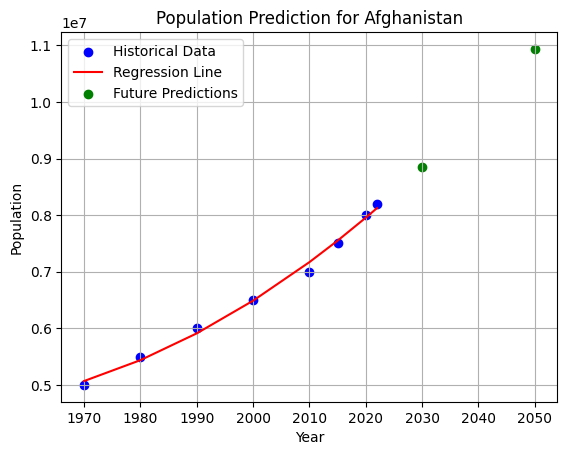

In [17]:
import matplotlib.pyplot as plt

# Historical data
years = [1970, 1980, 1990, 2000, 2010, 2015, 2020, 2022]
plt.scatter(years, y, color='blue', label='Historical Data')

# Regression line
plt.plot(years, model.predict(np.array(years).reshape(-1, 1)), 'r-', label='Regression Line')

# Predictions
plt.scatter(future_years, predictions, color='green', label='Future Predictions')

plt.xlabel('Year')
plt.ylabel('Population')
plt.title(f"Population Prediction for {population_df.iloc[0]['Country_Territory']}")
plt.legend()
plt.grid(True)
plt.show()